In [1]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

train_images = load_images_from_folder(r'C:\Users\vashi\OneDrive\Desktop\video_dat\archive (2)\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Train\Train001')
test_images = load_images_from_folder(r'C:\Users\vashi\OneDrive\Desktop\video_dat\archive (2)\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Test\Test001')

print(f"Loaded {len(train_images)} training images and {len(test_images)} testing images.")


Loaded 200 training images and 200 testing images.


In [3]:
def compute_optical_flow(image1, image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

train_flows = [compute_optical_flow(train_images[i], train_images[i+1]) for i in range(len(train_images)-1)]
test_flows = [compute_optical_flow(test_images[i], test_images[i+1]) for i in range(len(test_images)-1)]

print(f"Computed {len(train_flows)} training flows and {len(test_flows)} testing flows.")


Computed 199 training flows and 199 testing flows.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers

def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(100,)))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod((158, 238, 2)), activation='tanh'))
    model.add(layers.Reshape((158, 238, 2)))
    return model

def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(158, 238, 2)))
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())  # Flatten the input before the Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [7]:
import numpy as np
def train_gan(generator, discriminator, epochs, batch_size, train_flows):
    optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    discriminator.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    generated_flow = generator(gan_input)
    gan_output = discriminator(generated_flow)
    gan_model = tf.keras.Model(gan_input, gan_output)
    gan_model.compile(loss=loss_fn, optimizer=optimizer)

    for epoch in range(epochs):
        idx = np.random.randint(0, len(train_flows), batch_size)
        real_flows = np.array([train_flows[i] for i in idx])

        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_flows = generator.predict(noise)

        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_flows, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_flows, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)

        g_loss = gan_model.train_on_batch(noise, valid_y)

        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

generator = build_generator()
discriminator = build_discriminator()
train_gan(generator, discriminator, epochs=5, batch_size=32, train_flows=train_flows)


C:\Users\vashi\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


C:\Users\vashi\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6895046234130859, acc.: 56.25%] [G loss: [array(0.69098806, dtype=float32), array(0.69098806, dtype=float32), array(0.4375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1 [D loss: 0.6911835074424744, acc.: 45.44270932674408%] [G loss: [array(0.6917935, dtype=float32), array(0.6917935, dtype=float32), array(0.3984375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
2 [D loss: 0.6914554238319397, acc.: 44.37499940395355%] [G loss: [array(0.6918869, dtype=float32), array(0.6918869, dtype=float32), array(0.40625, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
3 [D loss: 0.6916866302490234, acc.: 41.85267686843872%] [G loss: [array(0.6920814, dtype=float32), array(0.6920814, dtype=float32), array(0.390625, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
4 [D loss: 0.6919245719909668, acc.: 40.2430534362793%] [G loss: [array(0.6924181, dtype=float32), array(0.6924181, dtype=float32), array(0.38125, dtype=float32)]]


In [9]:
def detect_anomalies(generator, test_flows):
    anomalies = []
    noise = np.random.normal(0, 1, (len(test_flows), 100))
    generated_flows = generator.predict(noise)

    for real_flow, generated_flow in zip(test_flows, generated_flows):
        error = np.mean(np.abs(real_flow - generated_flow))
        anomalies.append(error)

    return anomalies

anomalies = detect_anomalies(generator, test_flows)
threshold = np.mean(anomalies) + 2 * np.std(anomalies)
anomalous_images = [test_images[i] for i, anomaly in enumerate(anomalies) if anomaly > threshold]

print("Detected anomalies in the following images:")
for img in anomalous_images:
    cv2.imshow('Anomalous Image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Detected anomalies in the following images:


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [11]:
def evaluate_accuracy(anomalies, ground_truth):
    threshold = np.mean(anomalies) + 2 * np.std(anomalies)
    predictions = [1 if anomaly > threshold else 0 for anomaly in anomalies]
    accuracy = np.mean([1 if pred == gt else 0 for pred, gt in zip(predictions, ground_truth)])
    return accuracy

# Assuming ground_truth is a list of 0s (normal) and 1s (anomalous) for test images
ground_truth = [0] * len(test_flows)  # Placeholder, should be your actual ground truth labels
accuracy = evaluate_accuracy(anomalies, ground_truth)
print(f"Model accuracy: {accuracy * 100}%")


Model accuracy: 93.96984924623115%


Detected anomalies in the following images:


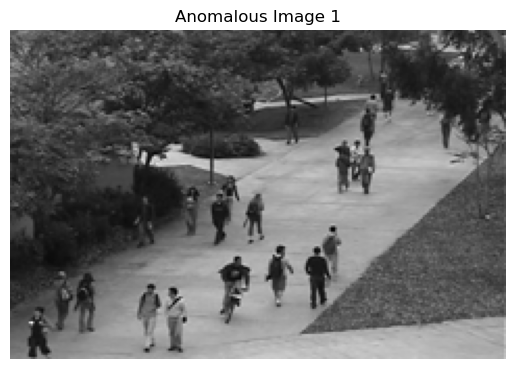

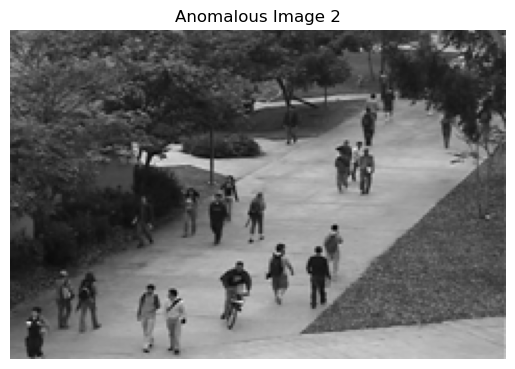

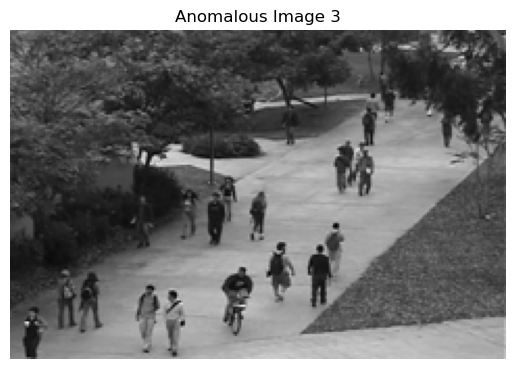

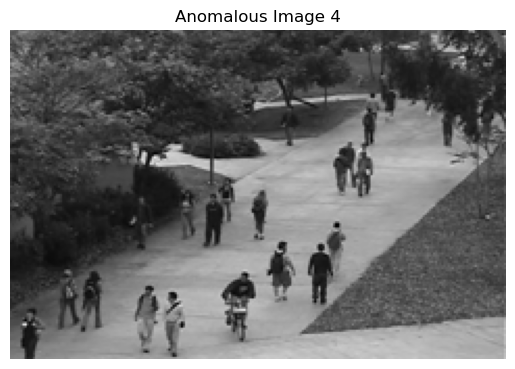

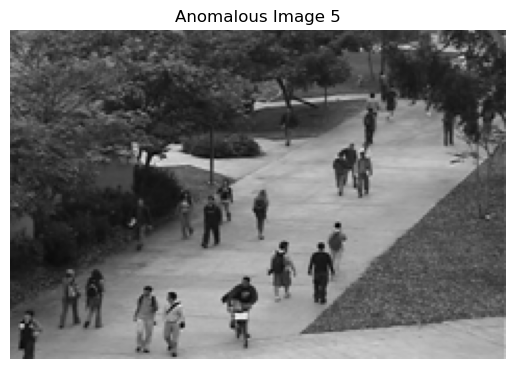

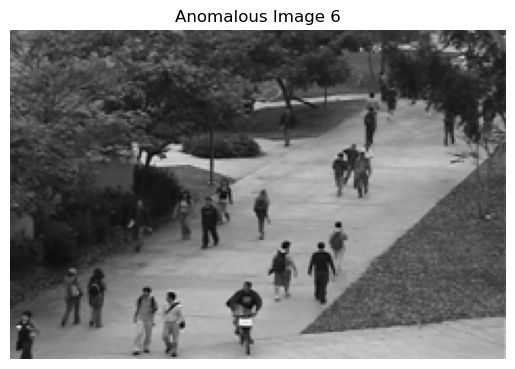

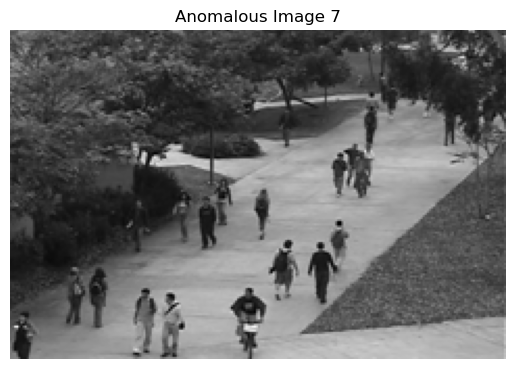

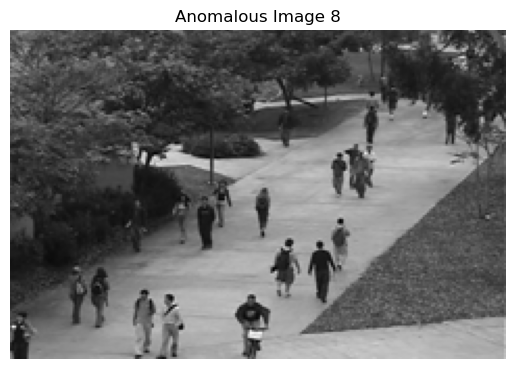

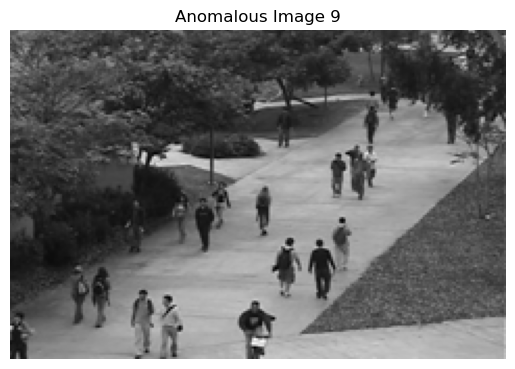

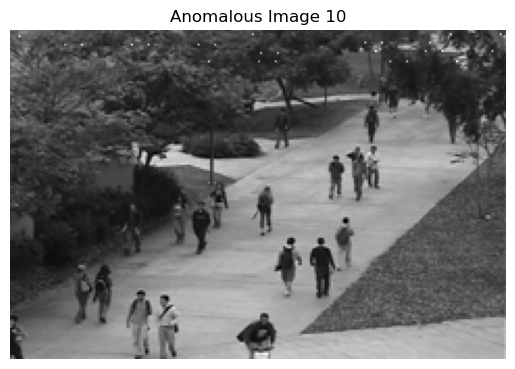

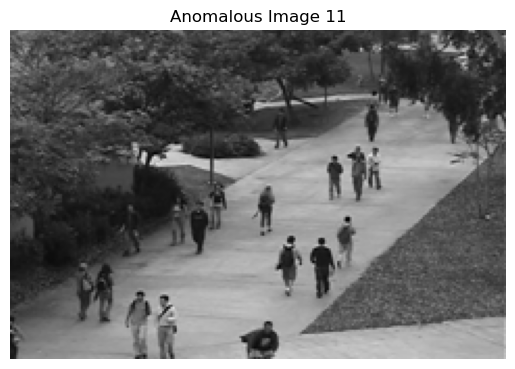

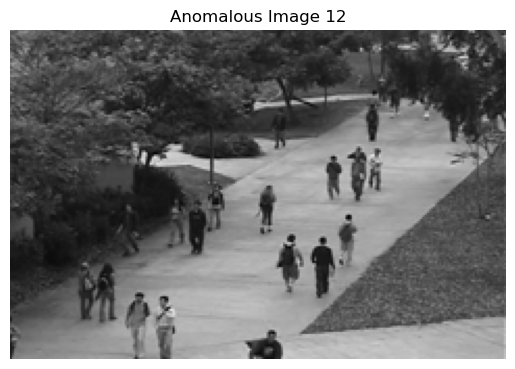

In [13]:
import cv2
import matplotlib.pyplot as plt

# Function to display images using matplotlib
def show_image(image, title='Image'):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

print("Detected anomalies in the following images:")
for i, img in enumerate(anomalous_images):
    show_image(img, title=f'Anomalous Image {i+1}')
